# NOTEBOOK FOR SURFACE TRAP

In [1]:
import matplotlib.pyplot as plt

from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.solver import solver, init_waveform

from pytrans.analysis import analyse_potential
from pytrans.analysis import analyse_waveform
from pytrans.plotting.plotting import plot_potential_make_layout

from optimization import load_fom, load_best_results
from qho_time_evolution import Param, Operators
from trap import SurfaceTrap, scale_pulse
from trap import animate_waveform_on_trap, plot_voltages_on_trap
import plot

/home/kallo27/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [21]:
timestamp = "20250309_120823"

fomlist = load_fom(timestamp)
timegrid, pulse = load_best_results(timestamp)

Files inside the archive: ['Pulse_1.npy', 'time_grid_for_Pulse_1.npy', 'pulse_names.npy', 'parameter_names.npy', 'time_names.npy', 'FoM.npy', 'iteration_number.npy', 'super_it.npy', 'status_code.npy']


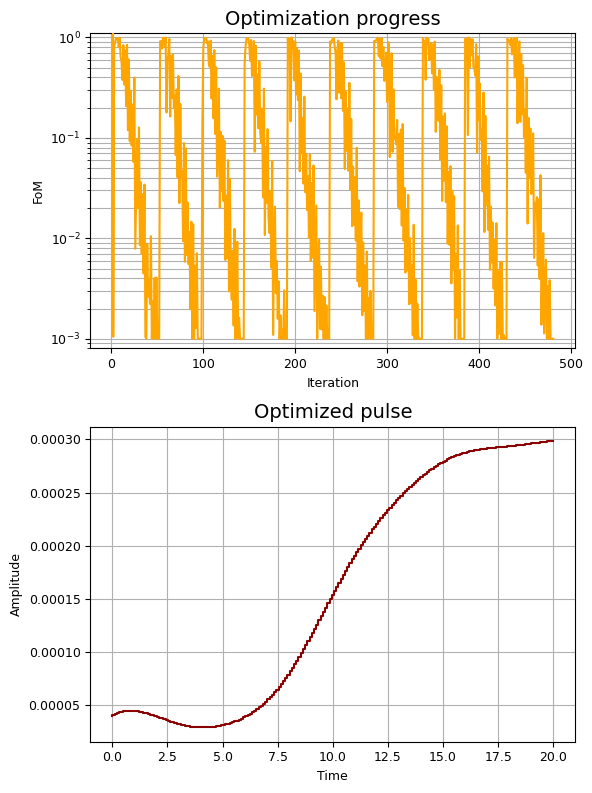

In [22]:
plot.plot_optimization_process(fomlist, timegrid, pulse)

In [23]:
# SIMULATION PARAMETERS

xmin = -20.0
xmax = 20.0
num_x = 4000
tsim = 20
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

# ===========================================================================================================

# INITIAL CONDITIONS -> ADD WFC OFFSET

res = num_x
omega = 1.0
num_wfcs = 8
T = 1

# Initialize the Operators object
opr = Operators(res, omega, num_wfcs, T, pulse, par)

In [24]:
opr.time_evolution(par, fixed_potential=False, compute_statistics=True)

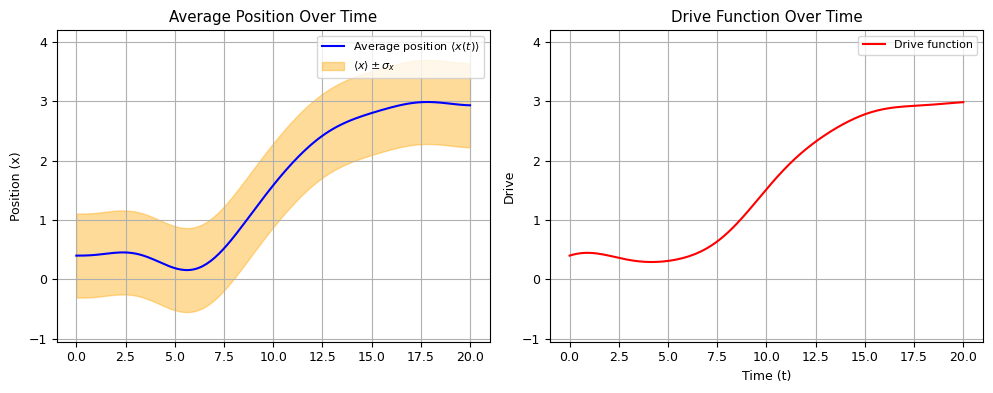

In [25]:
plot.plot_position_statistics(par, opr, 0)

In [26]:
#pulse = np.array(opr.avg_pos)[:, 0]

In [27]:
trap = SurfaceTrap()

In [28]:
axial = freq_to_curv(1e6, ion=Ca40)
rtilt = 6e7

n_samples = len(pulse)
x_start = trap.x_ele(2)
x_end = trap.x_ele(4) 
x = scale_pulse(pulse, x_start, x_end, method='sigmoid')
y0 = 0
z0 = trap.z0

waveform = init_waveform(n_samples, trap.n_electrodes)

In [29]:
objectives = []

# fill objectives per-step
def step_objective(voltages, x):
    return [
        obj.GradientObjective(voltages, trap, x, y0, z0, value=0, ion=Ca40),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='xx', value=axial, ion=Ca40, pseudo=False),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='yz', value=rtilt, ion=Ca40, pseudo=False),
    ]

for j, x0 in enumerate(x):
    objectives += step_objective(waveform[j], x0)

objectives += [
    obj.VoltageObjective(waveform, 0),
    obj.VoltageObjective(waveform, 10, constraint_type='<='),
    obj.VoltageObjective(waveform, -10, constraint_type='>='),
    obj.SlewRateObjective(waveform, dt=trap.dt, weight=1e4)
]

solver_results = solver(objectives, verbose=True, solver="ECOS")
waveform = solver_results.waveform.value

Compiling objectives:   0%|          | 0/604 [00:00<?, ?it/s]

Compiling objectives: 100%|██████████| 604/604 [00:02<00:00, 264.26it/s]


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Mar 09 06:43:37 PM: Your problem has 2400 variables, 4800 constraints, and 0 parameters.
(CVXPY) Mar 09 06:43:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 09 06:43:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 09 06:43:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 09 06:43:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 09 06:43:37 PM: Compiling problem (target solver=ECOS).

/home/kallo27/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


27  +6.134e+04  +6.134e+04  +5e-02  9e-11  5e-11  9e-06  5e-06  0.9363  3e-02   1  2  2 |  0  0
28  +6.134e+04  +6.134e+04  +5e-03  1e-06  6e-12  9e-07  5e-07  0.9890  8e-02   0  1  1 |  0  0
Unreliable search direction detected, recovering best iterate (26) and stopping.

Close to OPTIMAL (within feastol=1.6e-10, reltol=8.1e-06, abstol=5.0e-01).
Runtime: 0.485272 seconds.

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Mar 09 06:43:40 PM: Problem status: optimal_inaccurate
(CVXPY) Mar 09 06:43:40 PM: Optimal value: 6.134e+04
(CVXPY) Mar 09 06:43:41 PM: Compilation took 2.914e+00 seconds
(CVXPY) Mar 09 06:43:41 PM: Solver (including time spent in interface) took 4.887e-01 seconds


--------------
Trap potential analysis for ion Ca40: 
Equilibrium position [um]
[96.0633  0.0002 67.0797]
Gradient [V/m]
[-0.1423 -0.0034 -1.3258]
Displacement at 1 MHz [um]
[-0.0087 -0.0002 -0.0811]
Hessian [V/m2]
[[ 1.6351e+07 -4.9761e+05 -4.9873e+05]
 [-4.9761e+05  6.2822e+08  6.0000e+07]
 [-4.9873e+05  6.0000e+07  5.6458e+08]]
Normal mode frequencies [MHz]
[0.999973 5.68512 6.37399]
Eigenvectors
[[1 0.000732 0.00083]
 [0.000334 0.515 -0.857]
 [-0.00105 0.857 0.515]]
Tilt angle of mode 2 (6.37): 31.03°

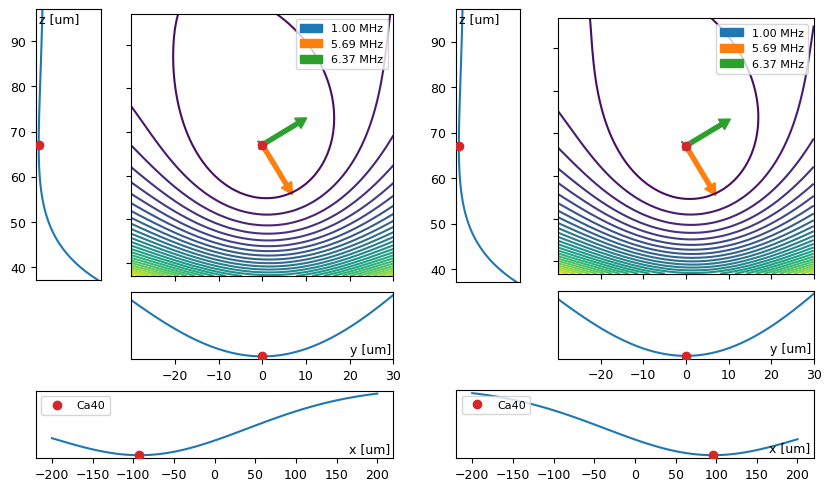

In [30]:
r0 = (0, 0, trap.z0)
roi = ((-200e-6, 200e-6), 30e-6, 30e-6)

fig, axes = plot_potential_make_layout(2)
res1 = analyse_potential(trap, voltages=waveform[0], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axes[0])
res2 = analyse_potential(trap, voltages=waveform[-1], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axes[1])

res2

In [31]:
results = analyse_waveform(trap, waveform, ions=[Ca40, Ca40], ion1=Ca40, r0=r0, roi=roi)

Waveform analysis: 100%|██████████| 200/200 [00:21<00:00,  9.48it/s]


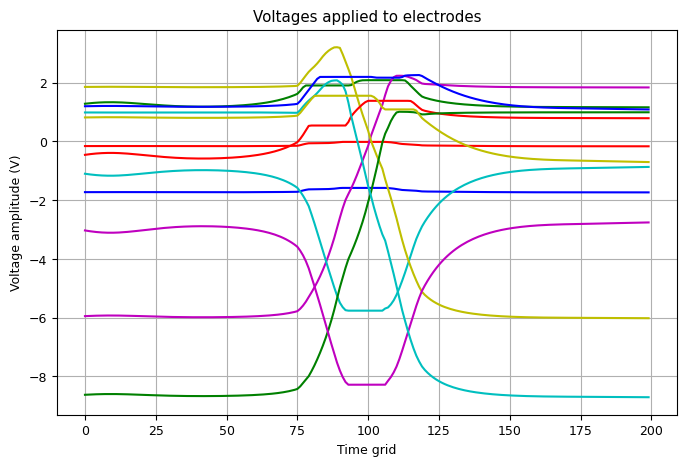

In [32]:
colors = ['b', 'r', 'g', 'm', 'c', 'y']  # Define a color palette

plt.figure(figsize=(8, 5))

# Plot each waveform with a different color and label
for i, w in enumerate(waveform.T):
  plt.plot(w, color=colors[i % len(colors)])

plt.xlabel("Time grid")
plt.ylabel("Voltage amplitude (V)")
plt.title("Voltages applied to electrodes")
plt.grid(True)
plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


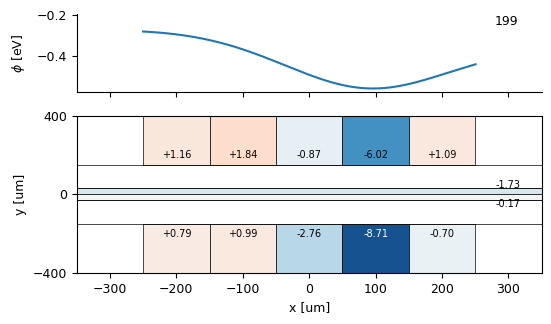

In [33]:
ani = animate_waveform_on_trap(trap, waveform)
ani.save('waveform_transport.gif', fps=20)

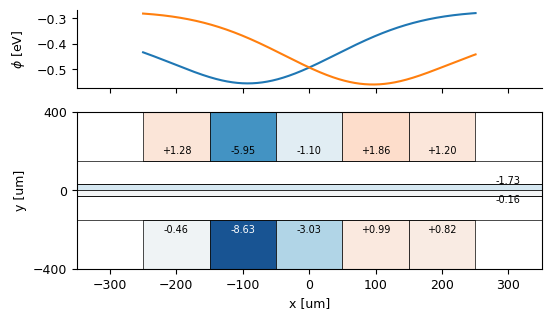

In [34]:
fig, (ax, ax0) = plot_voltages_on_trap(trap, waveform[0])
x = trap.x
p = trap.potential(waveform[-1], x, 0, trap.z0, Ca40.mass_amu)
ax.plot(x*1e6, p)